In [1]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

import ctapipe as cta

import matplotlib.pylab as plt
import astropy.units as u
import numpy as np

from ctapipe.image import toymodel, hillas_parameters, tailcuts_clean
from ctapipe.instrument import CameraGeometry
from ctapipe.visualization import CameraDisplay
import itertools
from matplotlib.lines import Line2D
from matplotlib.patches import Arc
import math

import seaborn as sns

In [2]:
sns.set_style('darkgrid')
sns.despine()

<Figure size 432x288 with 0 Axes>

In [3]:
# https://stackoverflow.com/questions/25227100/best-way-to-plot-an-angle-between-two-lines-in-matplotlib
def get_angle_plot(line1, line2, offset = 1, color = None, origin = [0,0], len_x_axis = 1, len_y_axis = 1, invert=False):

    l1xy = line1.get_xydata()
    # Angle between line1 and x-axis
    slope1 = (l1xy[1][1] - l1xy[0][1]) / float(l1xy[1][0] - l1xy[0][0])
    angle1 = abs(math.degrees(math.atan(slope1))) # Taking only the positive angle

    l2xy = line2.get_xydata()

    # Angle between line2 and x-axis
    slope2 = (l2xy[1][1] - l2xy[0][1]) / float(l2xy[1][0] - l2xy[0][0])
    angle2 = abs(math.degrees(math.atan(slope2)))

    theta1 = min(angle1, angle2)
    theta2 = max(angle1, angle2)

    angle = theta2 - theta1
    if invert: 
        theta1 += 180
        theta2 += 180

    if color is None:
        color = line1.get_color() # Uses the color of line 1 if color parameter is not passed.
    
    ret = Arc(
        origin, len_x_axis*offset, len_y_axis*offset,
        0, theta1, theta2, 
        color=color, label = str(angle)+u"\u00b0")
    return ret

In [4]:
def hillas_params(image, file="", axis=False, position=False, disp_pos=False, cleaning=False):
    #np.random.seed = 42
    # Load the camera
    plt.figure(figsize=(10,10))
    #ax = fig.add_subplot(1,1,1)
    ax = plt.gca()
    geom = CameraGeometry.from_name("LSTCam")
    disp = CameraDisplay(geom)
    #disp.add_colorbar()

    # Create a fake camera image to display:


    # Apply image cleaning
    cleanmask = tailcuts_clean(
        geom, image, picture_thresh=10, boundary_thresh=5
    )
    clean = image.copy()
    clean[~cleanmask] = 0.0

    # Calculate image parameters
    hillas = hillas_parameters(geom, clean)
    #print(hillas)

    # Show the camera image and overlay Hillas ellipse and clean pixels
    if cleaning:
        disp.image = clean
    else:
        disp.image = image
    disp.cmap = 'inferno'
    #disp.highlight_pixels(cleanmask, color='crimson')
    source_x = -0.35
    source_y = 0.3    
    x_disp = hillas['x'].value - 0.7 * np.cos(hillas['psi'].value)
    y_disp = hillas['y'].value - 0.7 * np.sin(hillas['psi'].value)
    x_disp_2 = hillas['x'].value + 0.7 * np.cos(hillas['psi'].value)
    y_disp_2 = hillas['y'].value + 0.7 * np.sin(hillas['psi'].value)

    if axis:
        disp.overlay_moments(hillas, color='cyan', linewidth=2, with_label=False)
        #print(hillas['x'].value)
        x2 = hillas['x'].value + 2.1 * np.cos(hillas['psi'].value)# + hillas['y'].value * np.sin(hillas['psi'].value)
        x2_ = hillas['x'].value - 1.8 * np.cos(hillas['psi'].value)
        y2 = hillas['y'].value + 2.1 * np.sin(hillas['psi'].value)
        y2_ = hillas['y'].value - 1.8 * np.sin(hillas['psi'].value)
        x = hillas['x'].value
        y = hillas['y'].value
        main_shower_axis = Line2D([x2, x2_], [y2, y2_], linewidth=2, linestyle = "-", color="blue")
        origin_cog_line = Line2D([0, x], [0, y], linewidth=2, linestyle = "-", color="green")
        horizontal_line = Line2D([-1.5, 1.5], [0, 0], linewidth=2, linestyle = "-", color="red")
        ax.add_line(origin_cog_line)
        ax.add_line(horizontal_line)
        ax.add_line(main_shower_axis)
        psi_plot = get_angle_plot(origin_cog_line, main_shower_axis, 0.6, origin=[x,y], invert=True, color='cyan')
        phi_plot = get_angle_plot(horizontal_line, origin_cog_line, 0.3, color='cyan')
        ax.add_patch(psi_plot)
        ax.add_patch(phi_plot)
        plt.text(0.15, 0.05, r'$\phi$', color='cyan', fontdict={'size': 33})
        plt.text(0.09, 0.30, r'$\psi$', color='cyan', fontdict={'size': 33})
        plt.text(x, y+0.03, r'$x,y$', color='black', fontdict={'size': 33})
        plt.xlim(-1.2, 1.2)
        plt.ylim(-1.2, 1.2)
        plt.plot(x, y, 'co')
    if disp_pos and position:
        plt.plot([source_x, x_disp], [source_y, y_disp], 'w--', linewidth=2)
        plt.text((source_x+x_disp)/2+0.01, (source_y+y_disp)/2+0.01, r'$\theta$', color='yellow', fontdict={'size': 30})
    if position:
        plt.plot(source_x, source_y, 'bo')
        plt.text(source_x-0.35, source_y, 'True position', color='white', fontdict={'size': 14})
    if disp_pos:
        plt.plot(x_disp, y_disp, 'yo', markersize=8)
        plt.plot(x_disp_2, y_disp_2, 'yo', markersize=10)
        plt.text(x_disp-0.02, y_disp-0.08, 'DISP-prediction', color='white', fontdict={'size': 12})
        plt.text(x_disp_2-0.02, y_disp_2-0.08, 'DISP-prediction', color='black', fontdict={'size': 12})

    
    disp.axes.set_title('')
    plt.axis('off')

    if file:
        plt.savefig(file)
    else:
        return plt.gcf()
#        plt.show()

/scratch/lnickel/conda/envs/test2/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/scratch/lnickel/conda/envs/test2/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/scratch/lnickel/conda/envs/test2/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/scratch/lnickel/conda/envs/test2/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might

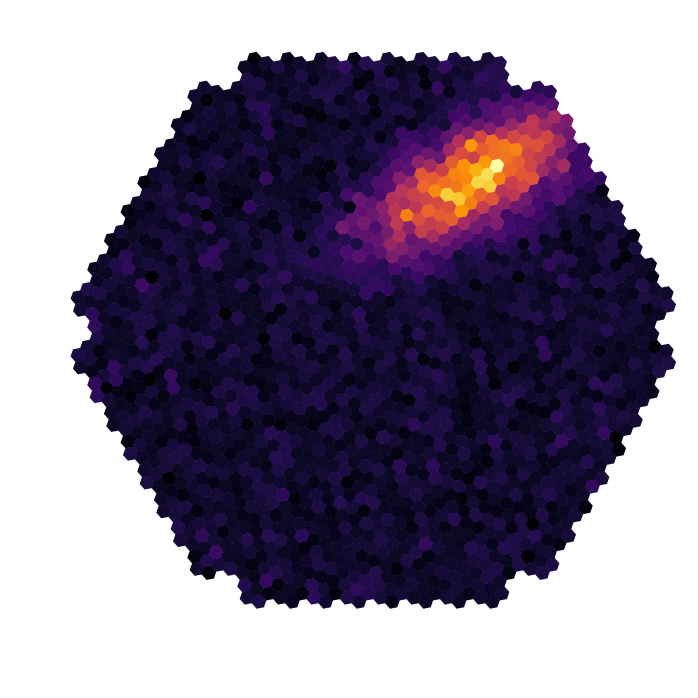

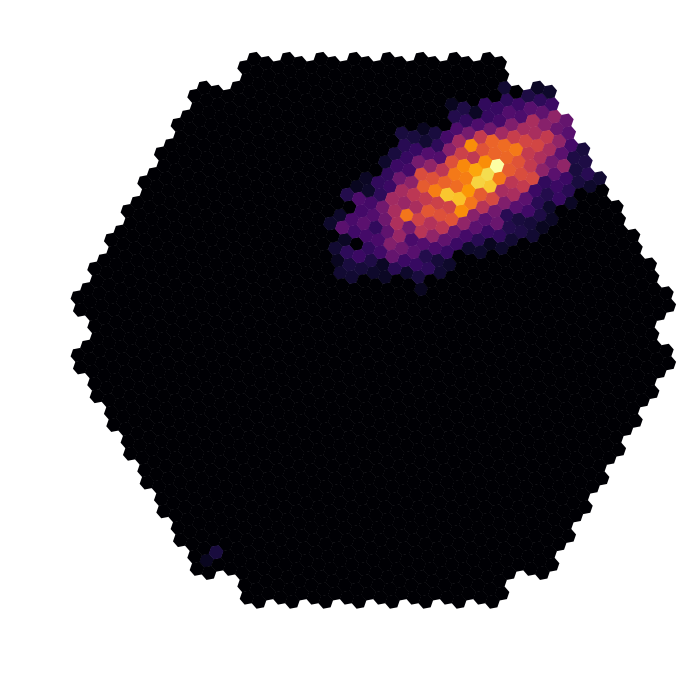

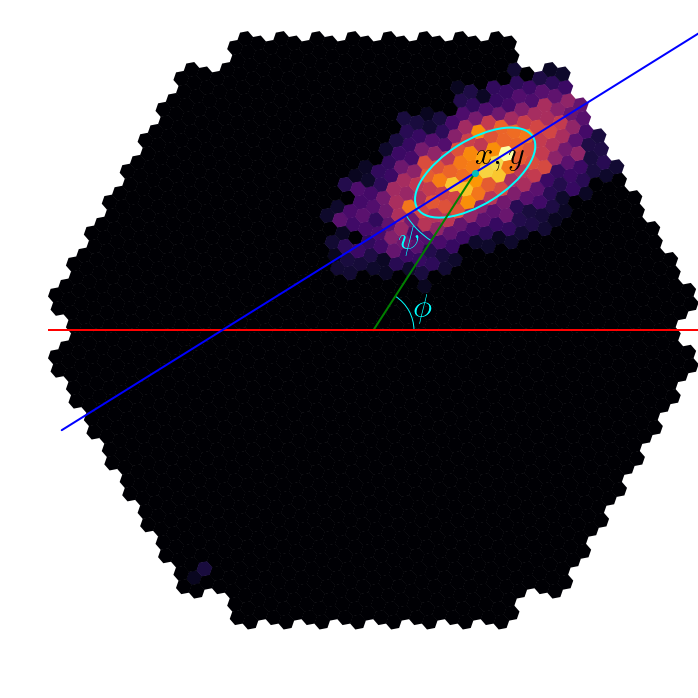

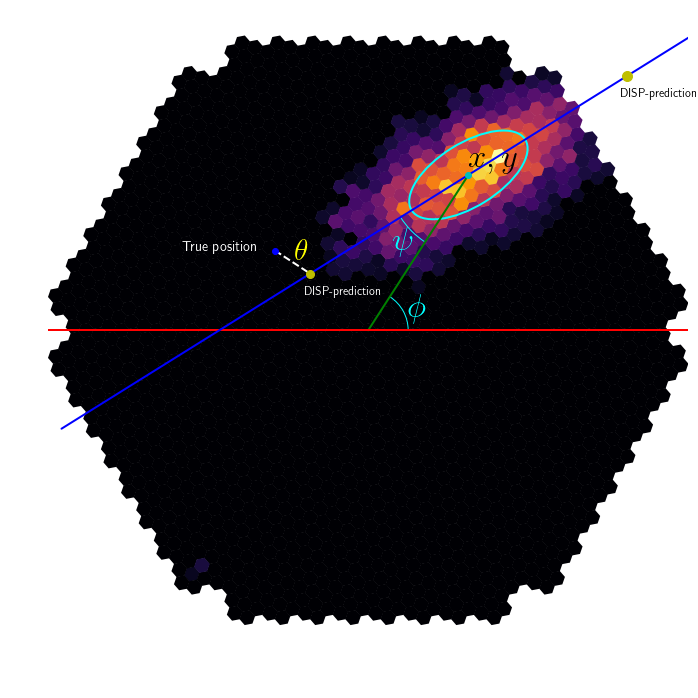

In [5]:
geom = CameraGeometry.from_name("LSTCam")

np.random.seed = 5
model = toymodel.Gaussian(
    x=0.4 * u.m, y=0.6 * u.m,
    width=0.12 * u.m, length=0.3 * u.m,
    psi='30d'
)

image, sig, bg = model.generate_image(
    geom, intensity=8000, nsb_level_pe=10
)

hillas_params(image, file='../Plots/hillas_raw.pdf')
hillas_params(image, cleaning=True, file='../Plots/hillas_cleaned.pdf')
hillas_params(image, axis=True, cleaning=True, file='../Plots/hillas_cleaned_params.pdf')
hillas_params(image, axis=True, position=True, disp_pos=True, cleaning=True, file='../Plots/hillas_complete.pdf')

In [31]:
def magic_stereo_disp(n=2, highlight=[], file=None, compare=False, prediction=False):
    plt.figure(figsize=(8,6))
    disps = [
        [[0.6, 2.1], [0, 0]],
        [[0.5, 2.3], [1, -0.2]],
        [[0.7, 2.4], [-0.1, -1.6]],
        [[0.5, 2.05], [1, -1.25]],]
    
    for i, disp in zip(range(n), disps):
        if i in highlight:
            a = 1
        else:
            a = 0.1
        plt.plot(
            [disp[0][0], disp[1][0]],
            [disp[0][1], disp[1][1]],
            'b-',
            alpha=a,
            linewidth=1)
        plt.plot(
            [disp[0][0], disp[1][0]],
            [disp[0][1], disp[1][1]],
            'yo',
            alpha=a,
            markersize=10)
        plt.plot(
            (disp[0][0] + disp[1][0])/2,
            (disp[0][1] + disp[1][1])/2,
            'kH',
            markersize=15)
    
    
    disp_combinations = itertools.combinations(range(4), 2)
    min_distance = 1 # 0.22?
    result_alt = np.nan
    result_az = np.nan
    result_az_list = []
    result_alt_list = []
    if highlight:
        candidates = np.array([
            disps[highlight[0]][0],
            disps[highlight[0]][1],
            disps[highlight[1]][0],
            disps[highlight[1]][1]])
        for pair in disp_combinations:
            distance = np.sqrt(
                (candidates[pair[0]][1] - candidates[pair[1]][1])**2
                +(candidates[pair[0]][0] - candidates[pair[1]][0])**2)

            if distance < min_distance:
                min_distance = distance
                winner = pair
                alt_mean = np.average(
                    [candidates[pair[0]][0], candidates[pair[1]][0]])
                az_mean = np.average(
                    [candidates[pair[0]][1], candidates[pair[1]][1]])
                result_alt = alt_mean
                result_az = az_mean
                result_alt_list.append(result_alt)
                result_az_list.append(result_az)
    
        if compare:
            plt.plot(
                [candidates[winner[0]][0], candidates[winner[1]][0]],
                [candidates[winner[0]][1], candidates[winner[1]][1]],
                'k-')
            plt.plot(result_alt, result_az, 'mo')
        if prediction:
            plt.plot(np.mean(result_alt), np.mean(result_az), 'c*', markersize=15)
            
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)
    plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelleft=False)

    if file:
        plt.savefig(file)
    else:
        return plt.gcf()
#        plt.show()

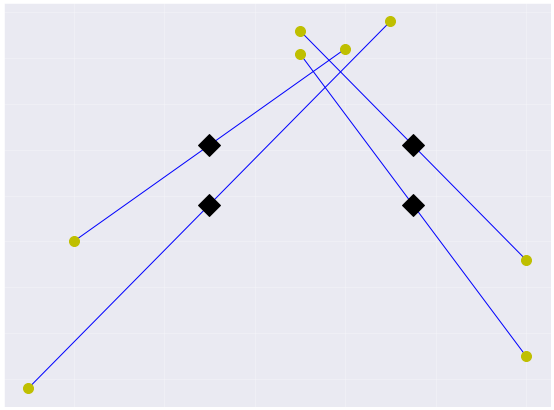

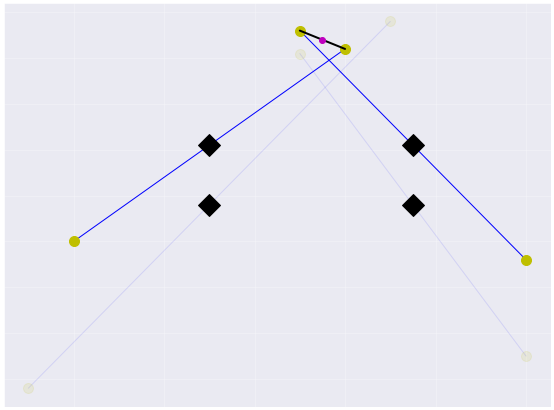

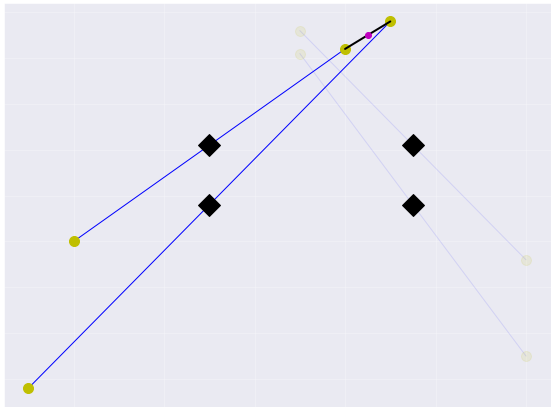

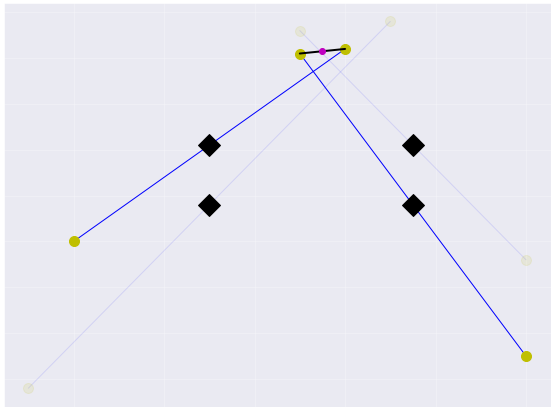

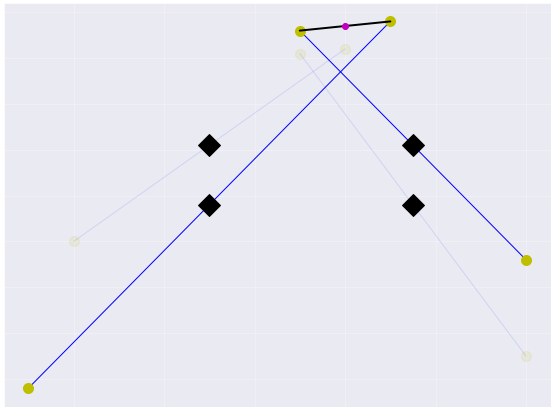

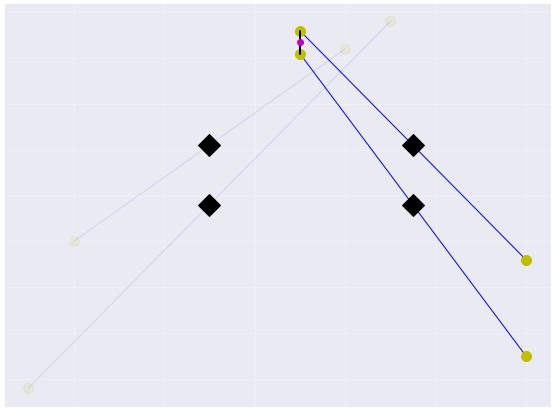

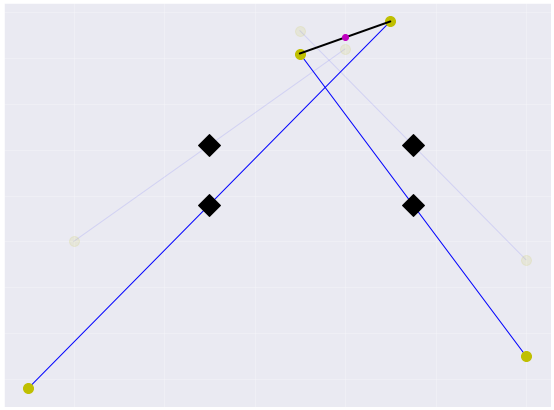

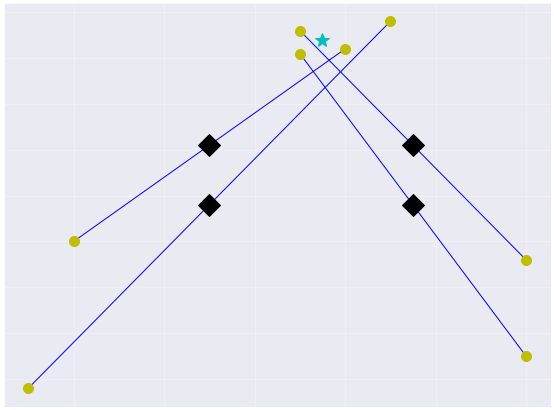

In [30]:
magic_stereo_disp(n=4, highlight=[0,1,2,3], file='../Plots/stereo_magic_all.pdf')
magic_stereo_disp(n=4, highlight=[0,1], file='../Plots/stereo_magic_1.pdf', compare=True)
magic_stereo_disp(n=4, highlight=[0,2], file='../Plots/stereo_magic_2.pdf', compare=True)
magic_stereo_disp(n=4, highlight=[0,3], file='../Plots/stereo_magic_3.pdf', compare=True)
magic_stereo_disp(n=4, highlight=[1,2], file='../Plots/stereo_magic_4.pdf', compare=True)
magic_stereo_disp(n=4, highlight=[1,3], file='../Plots/stereo_magic_5.pdf', compare=True)
magic_stereo_disp(n=4, highlight=[2,3], file='../Plots/stereo_magic_6.pdf', compare=True)
magic_stereo_disp(n=4, highlight=[0,1,2,3], file='../Plots/stereo_magic_result.pdf', prediction=True)